# NLP review regression exploration

Resources:

* [Medium Blog](https://medium.com/data-science-lab-spring-2021/amazon-review-rating-prediction-with-nlp-28a4acdd4352)

First, we import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Add any other imports you need here
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm_notebook
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# for animated plot
from IPython import display

In [2]:
# for work in google colab
import sys
if "google.colab" in sys.modules:
  from google.colab import drive, userdata
  # mount drive and set the root
  drive.mount('/content/drive', force_remount = True)
  FILEPATH = "/content/drive/Othercomputers/My Laptop/Documents/projects/iml-projects/4/" if os.path.exists("/content/drive/Othercomputers/") \
            else "/content/drive/MyDrive/projects/iml-projects/4/"
  # get the secret key
  userdata.get('HF_TOKEN')
else:
  raise("This notebook is intended to be run in google colab!")

Mounted at /content/drive


Depending on your approach, you might need to adapt the structure of this template or parts not marked by TODOs.
It is not necessary to completely follow this template. Feel free to add more code and delete any parts that are not required.

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_val = pd.read_csv(FILEPATH + "train.csv")
test_val = pd.read_csv(FILEPATH + "test_no_score.csv")

# download stopwords
nltk.download('stopwords')

train_val.describe()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,score
count,12500.000000
mean,4.967809
std,3.231226
min,0.000000
25%,2.036119
50%,4.795231
75%,8.122389
max,10.000000


In [ ]:
DEVICE

device(type='cpu')

In [4]:
def preprocess_text(df):
    # Concatenate headline and body
    df['combined_text'] = df['title'] + ' ' + df['sentence']

    # Normalizing text: lowercasing and handling whitespace/punctuation
    df['combined_text'] = df['combined_text'].str.lower()
    df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
    df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

    # Removing HTML tags
    df['combined_text'] = df['combined_text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())

    # Expanding contractions
    contractions = {
        "isn't": "is not",
        "can't": "cannot",
        "won't": "will not",
        "didn't": "did not",
        "i'm": "i am",
        "you're": "you are",
        "it's": "it is",
        "they're": "they are",
        "i've": "i have",
        "don't": "do not",
        "i'll": "i will",
        "you're": "you are",
        "we're": "we are",
        "weren't": "were not",
        "wouldn't": "would not",
        # Add more contractions as needed
    }
    df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'\b(' + '|'.join(contractions.keys()) + r')\b', lambda match: contractions[match.group()], x))

    # Remove stop words except 'not' and 'no'
    stop_words = set(stopwords.words('english')) - {'not', 'no'}
    df['combined_text'] = df['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return df

# BERT model with DataParallel
class BERTWithDP(nn.Module):
    def __init__(self):
        super(BERTWithDP, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        return self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]

# Function to generate BERT embeddings using DataParallel
def generate_bert_embeddings_dp(text_list):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BERTWithDP()
    model = nn.DataParallel(model)

    model.eval()
    embeddings = []


    for text in tqdm_notebook(text_list, unit = "sample"):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Get the embeddings for the [CLS] token
        cls_embeddings = outputs[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

    # Concatenate embeddings from all samples
    embeddings = torch.cat([torch.tensor(embedding) for embedding in embeddings], dim=0).numpy()
    return embeddings


In [5]:
# generate BERT embeddings using DataParallel
if not os.path.exists(FILEPATH + "bert_embeddings_train.npy"):
  # apply preprocessing
  train_val_preprocessed = preprocess_text(train_val)
  test_val_preprocessed = preprocess_text(test_val)

  # create the embeddings
  bert_embeddings_train = generate_bert_embeddings_dp(train_val_preprocessed['combined_text'].tolist())
  bert_embeddings_test = generate_bert_embeddings_dp(test_val_preprocessed['combined_text'].tolist())

  # save as npy
  np.save(FILEPATH + "bert_embeddings_train.npy",
          bert_embeddings_train)
  np.save(FILEPATH + "bert_embeddings_test.npy",
          bert_embeddings_test)

  # print(bert_embeddings_train.shape)  # Should output (number of samples, 768)

In [6]:
 # load the embeddings
bert_embeddings_train = np.load(FILEPATH + "bert_embeddings_train.npy")
bert_embeddings_test = np.load(FILEPATH + "bert_embeddings_test.npy")

In [7]:
# TODO: Fill out ReviewDataset
class ReviewDataset(Dataset):
    def __init__(self, data_frame):
        self.data_frame = data_frame

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.data_frame.iloc[index, :]

# Loader from last task
def create_loader_from_np(X, y = None, train = True, batch_size=50, shuffle=True, num_workers = 4):
    """
    Create a torch.utils.data.DataLoader object from numpy arrays containing the data.

    input: X: numpy array, the features
           y: numpy array, the labels

    output: loader: torch.data.util.DataLoader, the object containing the data
    """
    if train:
        dataset = TensorDataset(torch.from_numpy(X).type(torch.float),
                                torch.from_numpy(y).type(torch.float))
    else:
        dataset = TensorDataset(torch.from_numpy(X).type(torch.float))

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle,
                        pin_memory=True, num_workers=num_workers)
    return loader

In [8]:
BATCH_SIZE = 64

# split the training and validation set
train_indices, valid_indices = train_test_split(np.arange(len(bert_embeddings_train)), test_size=0.2, random_state=42)

train_loader = create_loader_from_np(bert_embeddings_train[train_indices], np.array(train_val["score"][train_indices]),
                                     train = True, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

valid_loader = create_loader_from_np(bert_embeddings_train[valid_indices], np.array(train_val["score"][valid_indices]),
                                     train = True, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

train_loader_total = create_loader_from_np(bert_embeddings_train, np.array(train_val["score"]),
                                          train = True, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

test_loader = create_loader_from_np(bert_embeddings_test,
                                     train = False, batch_size = 768, shuffle = False, num_workers = 2)

In [9]:
# Define the regression model
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Net(nn.Module):
    """
    The model class, which defines our classifier.
    """
    def __init__(self):
        """
        The constructor of the model.
        """
        super().__init__()

        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.out = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        The forward pass of the model.

        input: x: torch.Tensor, the input to the model

        output: x: torch.Tensor, the output of the model
        """


        # Forward pass through the network
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)

        return x

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predictions, targets):
        # Calculate Mean Squared Error (MSE) loss
        mse_loss = nn.MSELoss()(predictions, targets)

        # Penalize predictions outside [0, 10]
        outside_range_loss = torch.mean(torch.max(predictions - 10, torch.zeros_like(predictions))) + \
                             torch.mean(torch.max(0 - predictions, torch.zeros_like(predictions)))

        # Total loss is the sum of MSE loss and penalty for predictions outside the range
        total_loss = mse_loss + outside_range_loss

        return total_loss

Training Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


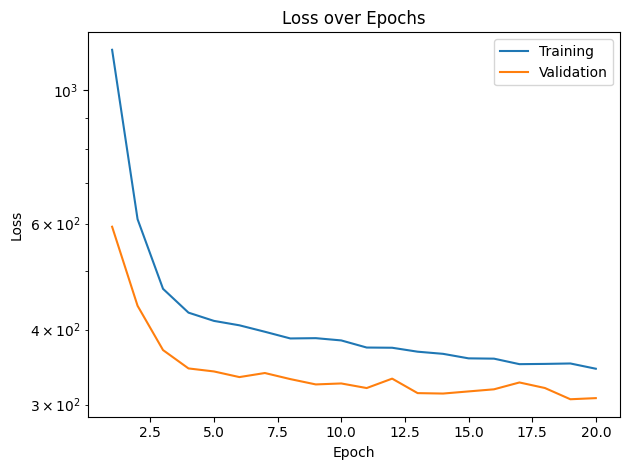

In [10]:
# define training hyperparams
NUM_EPOCHS = 20

# Define hyperparameters
input_size = bert_embeddings_train.shape[1]
hidden_size = 128  # Adjust as needed
output_size = 1  # Regression task has a single output

# Instantiate the model
model = Net() # RegressionModel(input_size, hidden_size, output_size)
model.to(DEVICE)

# Define loss function, optimizer and learning rate scheduler
criterion = nn.MSELoss()
#criterion = CustomLoss()
criterion.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
# optimizer.to(DEVICE)

# initialize loss lists
epoch_losses = np.zeros((NUM_EPOCHS, 2))
epoch_accuracies = np.zeros((NUM_EPOCHS, 2))

# set up the data_loader_list
data_loader_list = [train_loader, valid_loader]

with tqdm_notebook(range(1, NUM_EPOCHS + 1), unit = "epochs", desc = "Training Progress") as epoch_bar:
  for epoch in epoch_bar:

      # training and validation phase
      for i_train, train in enumerate([True, False]):

        # set phase string
        phase = "Train" if train else "Valid"

        # set model mode
        if train:
            model.train()
        else:
            model.eval()

        # init epoch loss and corrects
        running_loss = 0.0
        running_mse = 0
        total_labels = 0
        i = 1


        # print(model.training)
        for inputs, targets in data_loader_list[i_train]: # tqdm_notebook(train_loader, unit="batch", desc=f"Epoch: {epoch}"):

            if train: epoch_bar.set_postfix({"loss": running_loss / i})
            # Move inputs and targets to the device
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)

             # set the gradient to zero
            optimizer.zero_grad()

            # step forward, track only if in train
            with torch.set_grad_enabled(train):
                outputs = model(inputs)

                preds = torch.mean(torch.abs(targets - outputs))
                loss = criterion(outputs, targets.unsqueeze(1))

                # propagate backwards if in train phase
                if train:
                    loss.backward()
                    optimizer.step()


            # calculate stats
            running_loss += loss.item() * inputs.size(0)
            running_mse += preds.item()
            total_labels += len(targets)
            i += 1

        # if train:
        #     scheduler.step()

        # print(phase, running_loss / i)
        epoch_losses[(epoch - 1), i_train] = running_loss / i
        epoch_accuracies[(epoch - 1), i_train] = running_mse / max(1, total_labels)

fig, ax = plt.subplots(1, 1)
for i, loss_str in enumerate(["Training", "Validation"]):
  ax.semilogy(np.arange(1, NUM_EPOCHS + 1, 1), epoch_losses[:, i], label = f"{loss_str}")

ax.set_title("Loss over Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.tight_layout()
plt.show()

In [15]:
# now train on all data

# Instantiate the model
model = Net()# RegressionModel(input_size, hidden_size, output_size)
model.to(DEVICE)
model.train()

# Define loss function, optimizer and learning rate scheduler
criterion = nn.MSELoss()
#criterion = CustomLoss()
criterion.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

for epoch in tqdm_notebook(range(NUM_EPOCHS)):

    running_loss = 0.0
    for i, [features, labels] in enumerate(train_loader_total):
        features.to(DEVICE)
        labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
# TODO: Setup loss function, optimiser, and scheduler
criterion = None
optimiser = None
scheduler = None

model.train()
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch in tqdm(train_loader, total=len(train_loader)):
        batch = batch.to(DEVICE)

        # TODO: Set up training loop

In [ ]:
model.eval()
with torch.no_grad():
    results = []
    for batch in tqdm_notebook(test_loader, desc = "Evaluation Progress"):
        batch = batch[0].to(DEVICE)
        result = model(batch).cpu().numpy()
        results.append(result)
    results = np.vstack(results).reshape(-1)
    with open(FILEPATH + "result.txt", "w") as f:
        for val in results:
            f.write(f"{val}\n")

Evaluation Progress:   0%|          | 0/2 [00:00<?, ?it/s]